In [6]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


In [9]:
ab = pd.read_csv(r"C:\Users\ALKA\OneDrive\Desktop\Data Analytics project\Softnix internship\Extractdir\ab_data.csv")
ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [11]:
ab.shape

(294478, 5)

In [13]:
ab.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

In [14]:
# CHECH MISMATCHES
mismatch_control = ab[(ab['group']=='control') & (ab['landing_page']!='old_page')].shape[0]
mismatch_treatment = ab[(ab['group']=='treatment') & (ab['landing_page']!='new_page')].shape[0]
print(f"\nMismatched rows -> control but not old_page: {mismatch_control}, treatment but not new_page: {mismatch_treatment}")




Mismatched rows -> control but not old_page: 1928, treatment but not new_page: 1965


In [15]:
# Keep only consistent rows:
ab_clean = ab[ ((ab['group']=='control') & (ab['landing_page']=='old_page')) | 
               ((ab['group']=='treatment') & (ab['landing_page']=='new_page')) ].copy()

In [16]:
ab_clean.shape

(290585, 5)

In [17]:
# --- 2) Remove duplicate users if any ---
dups = ab_clean['user_id'].duplicated().sum()
print("Duplicate user_id count (before dropping):", dups)
ab_clean = ab_clean.drop_duplicates(subset='user_id', keep='first')
print("After dropping duplicates shape:", ab_clean.shape)

Duplicate user_id count (before dropping): 1
After dropping duplicates shape: (290584, 5)


In [18]:
# Ensure converted is integer 0/1
ab_clean['converted'] = ab_clean['converted'].astype(int)

In [19]:
# --- 3) Summary counts & rates ---
summary = ab_clean.groupby('group').agg(visitors=('user_id','count'),
                                        conversions=('converted','sum')).reset_index()
summary['conversion_rate'] = summary['conversions'] / summary['visitors']
summary_display = summary.copy()
summary_display['conversion_rate'] = summary_display['conversion_rate'].map("{:.4%}".format)
print("\nSummary (visitors, conversions, conversion_rate):")
print(summary_display.to_string(index=False))


Summary (visitors, conversions, conversion_rate):
    group  visitors  conversions conversion_rate
  control    145274        17489        12.0386%
treatment    145310        17264        11.8808%


In [32]:
# --- 4) Two-proportion Z-test ---
conv_old = int(summary.loc[summary['group']=='control','conversions'].values[0])
conv_new = int(summary.loc[summary['group']=='treatment','conversions'].values[0])
n_old = int(summary.loc[summary['group']=='control','visitors'].values[0])
n_new = int(summary.loc[summary['group']=='treatment','visitors'].values[0])

In [33]:
# --- 4) Two-proportion z-test (one-sided: treatment > control) ---
count = [conv_new, conv_old]
nobs = [n_new, n_old]
z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')
print(f"\nTwo-proportion Z-test (H1: treatment > control): Z = {z_stat:.4f}, p = {p_value:.6e}")




Two-proportion Z-test (H1: treatment > control): Z = -1.3109, p = 9.050583e-01


In [34]:
# --- 5) 95% Wilson confidence intervals ---
ci_old = proportion_confint(conv_old, n_old, alpha=0.05, method='wilson')
ci_new = proportion_confint(conv_new, n_new, alpha=0.05, method='wilson')

rate_old = conv_old / n_old
rate_new = conv_new / n_new
print(f"\nControl rate = {rate_old:.4%}, 95% CI = ({ci_old[0]:.4%}, {ci_old[1]:.4%})")
print(f"Treatment rate = {rate_new:.4%}, 95% CI = ({ci_new[0]:.4%}, {ci_new[1]:.4%})")


Control rate = 12.0386%, 95% CI = (11.8723%, 12.2070%)
Treatment rate = 11.8808%, 95% CI = (11.7154%, 12.0482%)


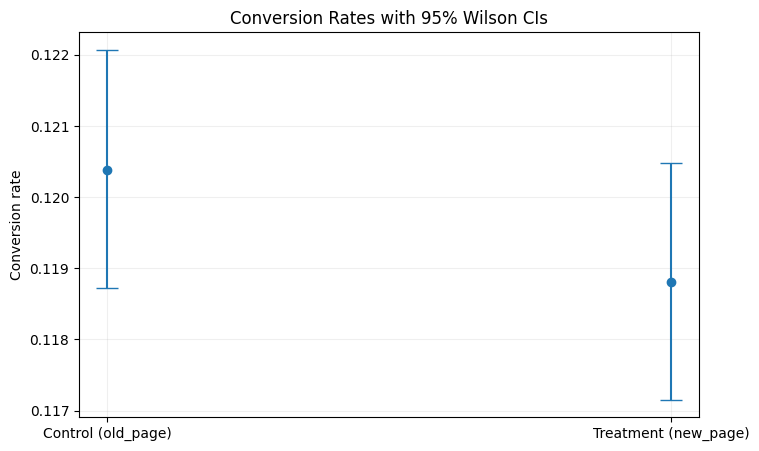

In [35]:
# --- 6) Plot conversion rates with CIs ---
plt.figure(figsize=(8,5))
x = [0, 1]
y = [rate_old, rate_new]
yerr = [[y[0]-ci_old[0], y[1]-ci_new[0]], [ci_old[1]-y[0], ci_new[1]-y[1]]]
plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=8)
plt.xticks(x, ['Control (old_page)', 'Treatment (new_page)'])
plt.ylabel('Conversion rate')
plt.title('Conversion Rates with 95% Wilson CIs')
plt.grid(alpha=0.2)
plt.show()

In [26]:
# Count conversions
convert_old = ab.query("group == 'control' and landing_page == 'old_page'")['converted'].sum()
convert_new = ab.query("group == 'treatment' and landing_page == 'new_page'")['converted'].sum()


In [27]:
# Sample sizes
n_old = ab.query("group == 'control' and landing_page == 'old_page'").shape[0]
n_new = ab.query("group == 'treatment' and landing_page == 'new_page'").shape[0]

In [28]:
# Z-test (H1: p_new > p_old → one-sided test)
count = np.array([convert_new, convert_old])
nobs = np.array([n_new, n_old])
z_stat, p_val = proportions_ztest(count, nobs, alternative='larger')

In [29]:
z_stat
p_val

np.float64(0.905173705140591)

In [30]:
# Confidence intervals
confint_new = proportion_confint(convert_new, n_new, alpha=0.05, method='wilson')
confint_old = proportion_confint(convert_old, n_old, alpha=0.05, method='wilson')


In [31]:

print("New page conversion CI:", confint_new)
print("Old page conversion CI:", confint_old)

New page conversion CI: (0.11715369008635894, 0.12048095969995574)
Old page conversion CI: (0.11872297704421185, 0.1220697075630713)
